Loading the Dataset

In [11]:
import pandas as pd
import numpy as np
data=pd.read_csv("train.csv")
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
!pip install pygam==0.8.0

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from pygam import LinearGAM
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import set_config

set_config(transform_output = 'pandas')

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)

In [14]:
data.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,year,Release Clause,DefensiveAwareness
0,0,195427,J. Stockley,22,https://cdn.sofifa.com/players/195/427/17_60.png,England,https://cdn.sofifa.com/flags/gb-eng.png,61,68,Aberdeen,...,14.0,6.0,15.0,9.0,12.0,ST,60.0,2017,NaN,NaN
1,1,203539,K. Devaney,25,https://cdn.sofifa.com/players/203/539/17_60.png,Republic of Ireland,https://cdn.sofifa.com/flags/ie.png,57,58,Galway United,...,6.0,12.0,13.0,12.0,10.0,RM,57.0,2017,NaN,NaN
2,2,232898,T. Morishima,23,https://cdn.sofifa.com/players/232/898/20_60.png,Japan,https://cdn.sofifa.com/flags/jp.png,71,76,Sanfrecce Hiroshima,...,13.0,15.0,6.0,15.0,6.0,CAM,74.0,2021,€4.2M,32.0
3,3,215502,B. Drągowski,18,https://cdn.sofifa.com/players/215/502/17_60.png,Poland,https://cdn.sofifa.com/flags/pl.png,71,86,Fiorentina,...,68.0,68.0,70.0,71.0,74.0,GK,70.0,2017,NaN,NaN
4,4,222263,N. Jackers,19,https://cdn.sofifa.com/players/222/263/18_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,64,75,KRC Genk,...,65.0,64.0,59.0,60.0,65.0,GK,63.0,2018,€978K,NaN


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87642 entries, 0 to 87641
Data columns (total 67 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                87642 non-null  int64  
 1   ID                        87642 non-null  int64  
 2   Name                      87642 non-null  object 
 3   Age                       87642 non-null  int64  
 4   Photo                     87642 non-null  object 
 5   Nationality               87642 non-null  object 
 6   Flag                      87642 non-null  object 
 7   Overall                   87642 non-null  int64  
 8   Potential                 87642 non-null  int64  
 9   Club                      86196 non-null  object 
 10  Club Logo                 87642 non-null  object 
 11  Value                     87642 non-null  object 
 12  Wage                      87642 non-null  object 
 13  Special                   87642 non-null  int64  
 14  Prefer

In [16]:
data.shape

(87642, 67)

Data Engineering 

In [17]:
data.isnull().sum()

Unnamed: 0                      0
ID                              0
Name                            0
Age                             0
Photo                           0
Nationality                     0
Flag                            0
Overall                         0
Potential                       0
Club                         1446
Club Logo                       0
Value                           0
Wage                            0
Special                         0
Preferred Foot                  0
International Reputation        0
Weak Foot                       0
Skill Moves                     0
Work Rate                       0
Body Type                      52
Real Face                      52
Position                       91
Jersey Number                  91
Joined                       8949
Loaned From                 80931
Contract Valid Until         2185
Height                          0
Weight                          0
Crossing                        0
Finishing     

Finding NullValues

In [18]:
null=data.isnull().sum()
null_val=null[null>0].index

In [19]:
null_val

Index(['Club', 'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined',
       'Loaned From', 'Contract Valid Until', 'Volleys', 'Curve', 'Agility',
       'Balance', 'Jumping', 'Interceptions', 'Positioning', 'Vision',
       'Composure', 'Marking', 'SlidingTackle', 'Release Clause',
       'DefensiveAwareness'],
      dtype='object')

Updating Null Values

In [20]:
for i in null_val:
 data[i]=data[i].fillna(value=data[i].mode()[0]) 

In [21]:
data.isnull().sum()

Unnamed: 0                  0
ID                          0
Name                        0
Age                         0
Photo                       0
Nationality                 0
Flag                        0
Overall                     0
Potential                   0
Club                        0
Club Logo                   0
Value                       0
Wage                        0
Special                     0
Preferred Foot              0
International Reputation    0
Weak Foot                   0
Skill Moves                 0
Work Rate                   0
Body Type                   0
Real Face                   0
Position                    0
Jersey Number               0
Joined                      0
Loaned From                 0
Contract Valid Until        0
Height                      0
Weight                      0
Crossing                    0
Finishing                   0
HeadingAccuracy             0
ShortPassing                0
Volleys                     0
Dribbling 

In [22]:
import sklearn
from sklearn.model_selection import train_test_split

Dropping Unneccessary Features

In [23]:
f=data[['Name','Photo','Flag','Club Logo']]

In [24]:
for i in f:
    data=data.drop(i,axis=1)

In [25]:
data.Wage

0         €2K
1        €500
2         €7K
3        €10K
4         €2K
         ... 
87637    €20K
87638     €1K
87639     €8K
87640     €3K
87641     €2K
Name: Wage, Length: 87642, dtype: object

Converting Euro to Integers

In [26]:
def convert_value(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('€', '').replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('€', '').replace('M', '')) * 1000000
        else:
            return float(value.replace('€', ''))
    else:
        return value
    
data['Value'] = data['Value'].apply(convert_value)
data['Wage'] = data['Wage'].apply(convert_value)
data['Release Clause'] = data['Release Clause'].apply(convert_value)

In [27]:
data['Release Clause']

0        1100000.0
1        1100000.0
2        4200000.0
3        1100000.0
4         978000.0
           ...    
87637    1100000.0
87638     155000.0
87639    1600000.0
87640    1700000.0
87641    1100000.0
Name: Release Clause, Length: 87642, dtype: float64

Finding String Data type Features

In [28]:
e=data.select_dtypes(include='object').columns

In [29]:
for i in e:
    data[i] = pd.factorize(data[i])[0]

In [30]:
ill=data.isnull().sum()
ill1=ill[ill>0].index
ill1

Index([], dtype='object')

In [31]:
y=data['Value'] 
x1=data
x=x1.drop('Value',axis=1)


In [32]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87642 entries, 0 to 87641
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                87642 non-null  int64  
 1   ID                        87642 non-null  int64  
 2   Age                       87642 non-null  int64  
 3   Nationality               87642 non-null  int64  
 4   Overall                   87642 non-null  int64  
 5   Potential                 87642 non-null  int64  
 6   Club                      87642 non-null  int64  
 7   Wage                      87642 non-null  float64
 8   Special                   87642 non-null  int64  
 9   Preferred Foot            87642 non-null  int64  
 10  International Reputation  87642 non-null  float64
 11  Weak Foot                 87642 non-null  float64
 12  Skill Moves               87642 non-null  float64
 13  Work Rate                 87642 non-null  int64  
 14  Body T

<Axes: >

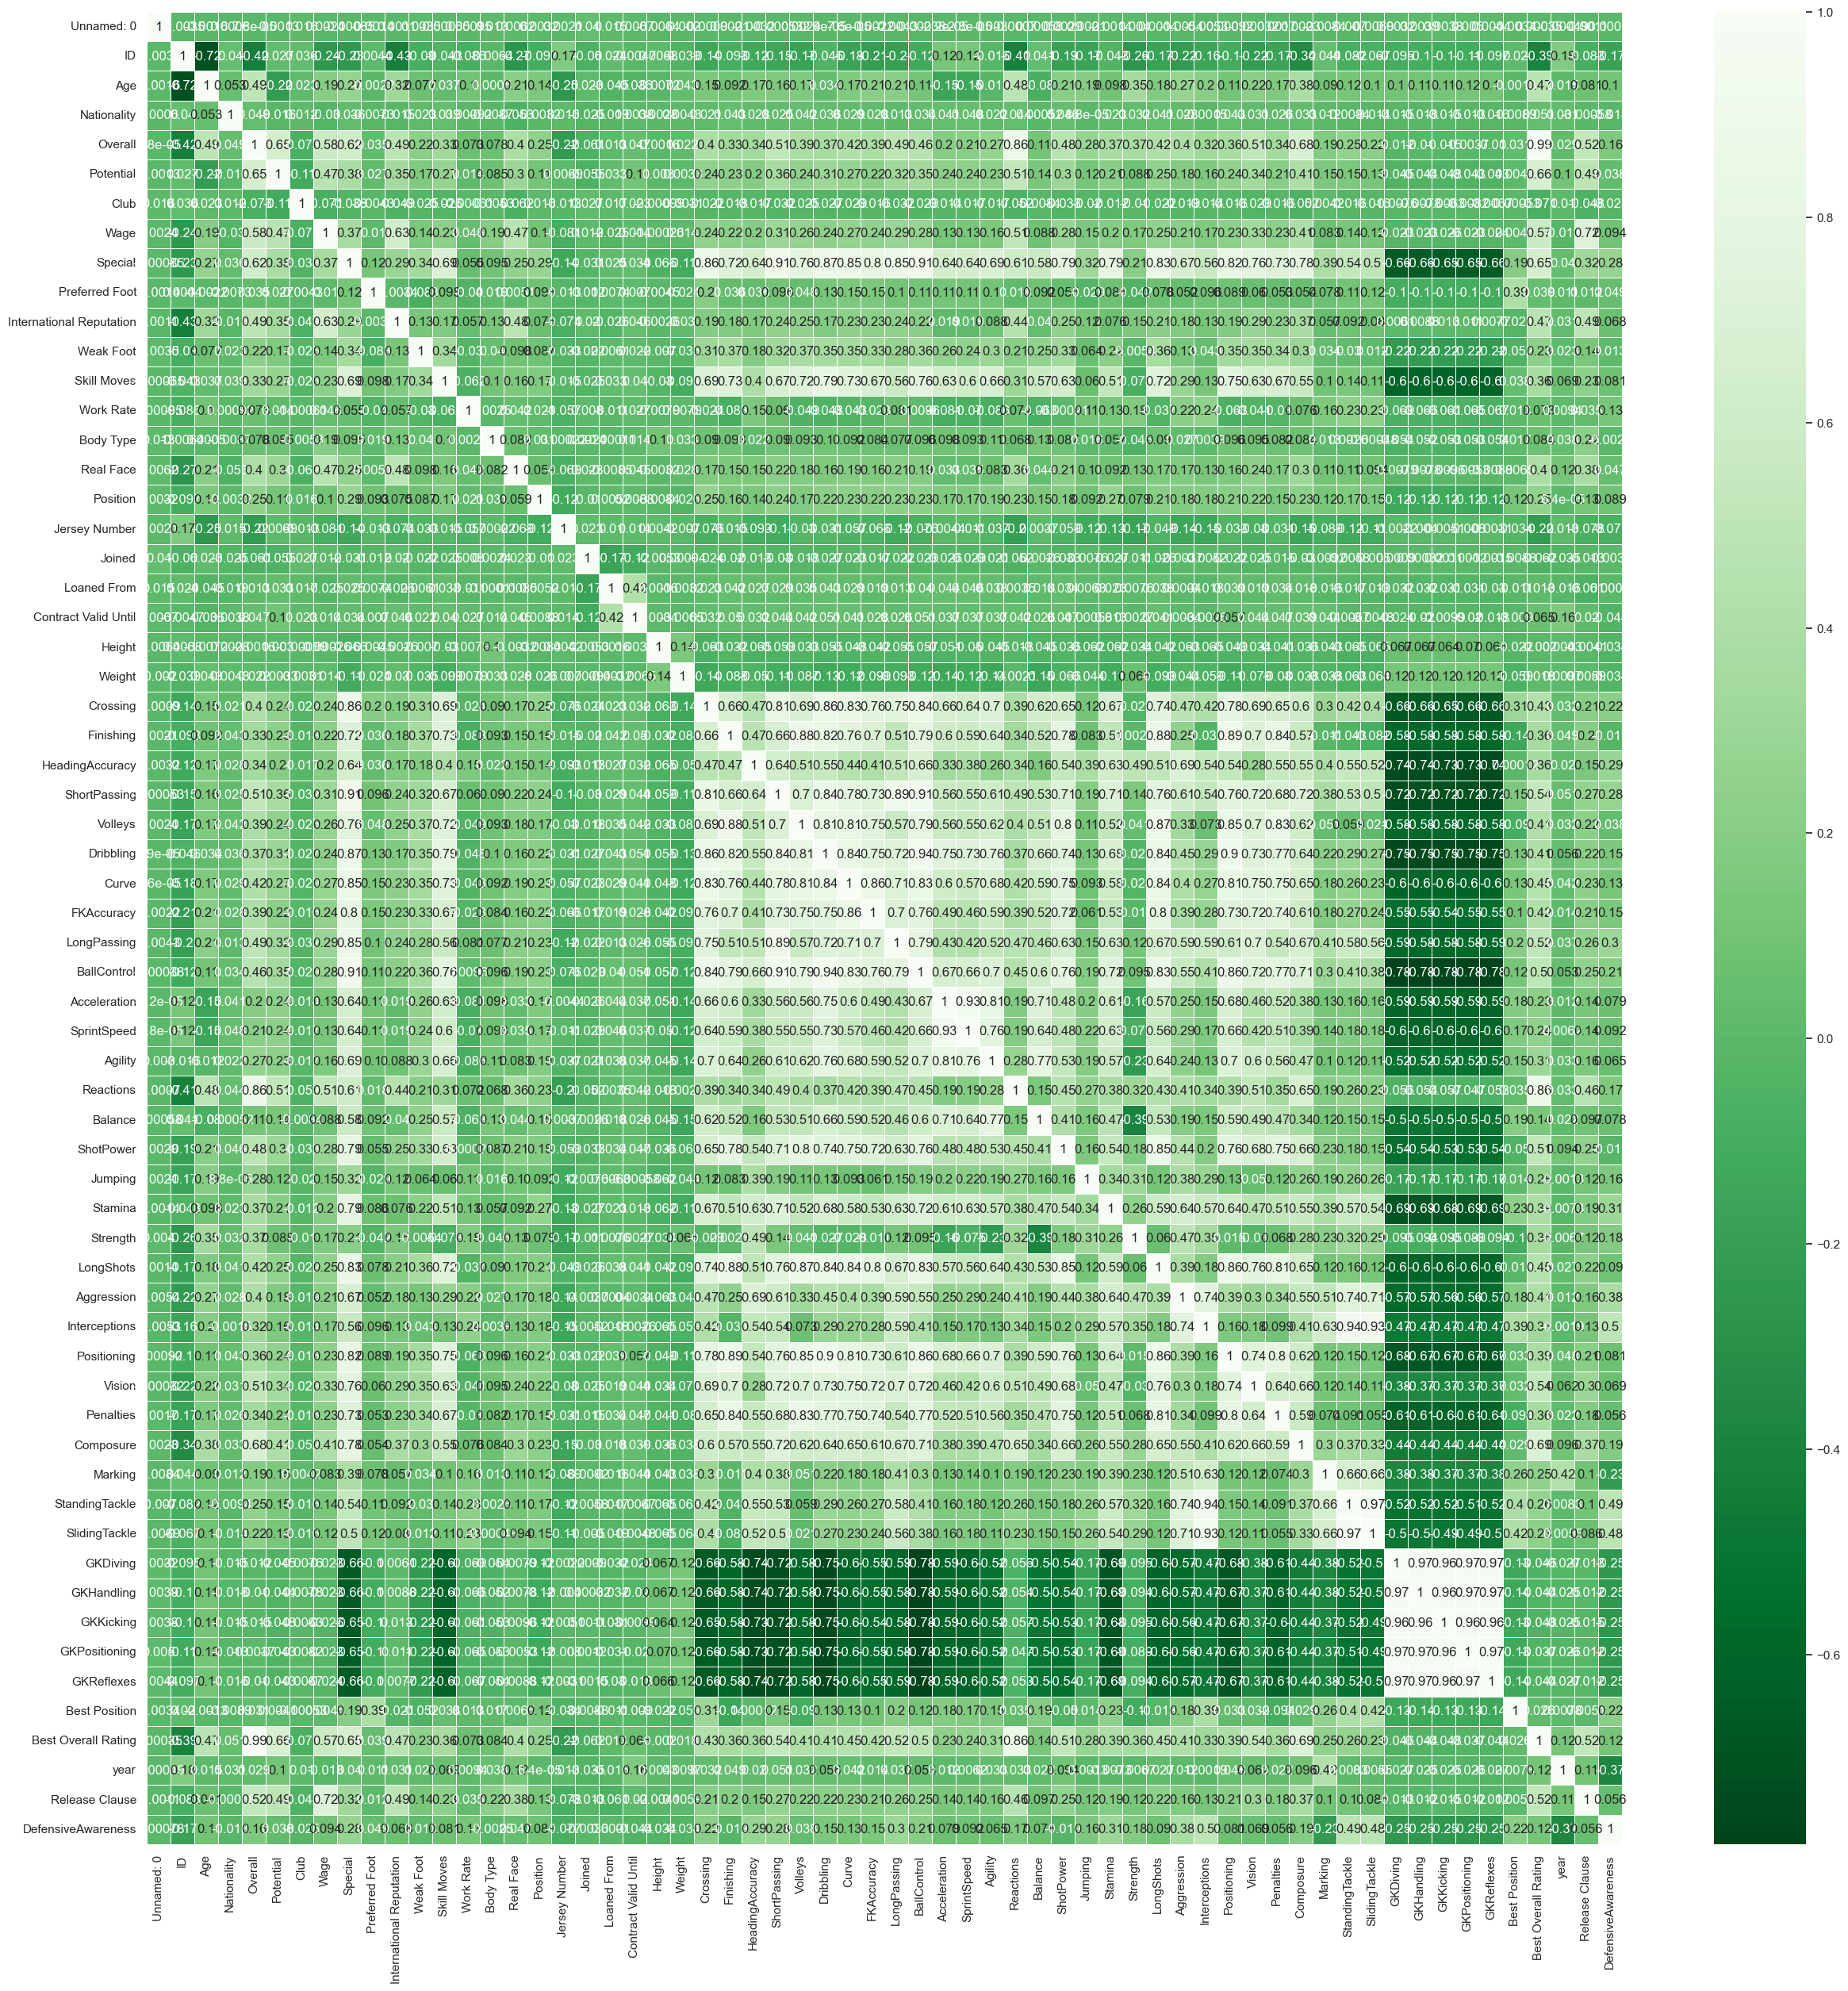

In [33]:
plt.figure(figsize=(30,30))
sns.heatmap(x.corr(),annot=True,linewidth=0.4,cmap='Greens_r')

In [34]:
x.columns

Index(['Unnamed: 0', 'ID', 'Age', 'Nationality', 'Overall', 'Potential',
       'Club', 'Wage', 'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face',
       'Position', 'Jersey Number', 'Joined', 'Loaned From',
       'Contract Valid Until', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position',
       'Best Overall Rating', 'year', 'Release Clause', 'DefensiveAwareness'],
      dtype='object')

Important Features

In [35]:
x_train,x_val,y_train,y_val=train_test_split(x,y,random_state=42,test_size=0.2)

In [36]:
from sklearn.feature_selection import RFE,RFECV

In [37]:
from lightgbm import LGBMRegressor

In [38]:
clf_li=LGBMRegressor()

In [39]:
selector= RFECV(estimator=clf_li,cv=5)

In [41]:
selector.fit(x_train,y_train)

RFECV(cv=5, estimator=LGBMRegressor())

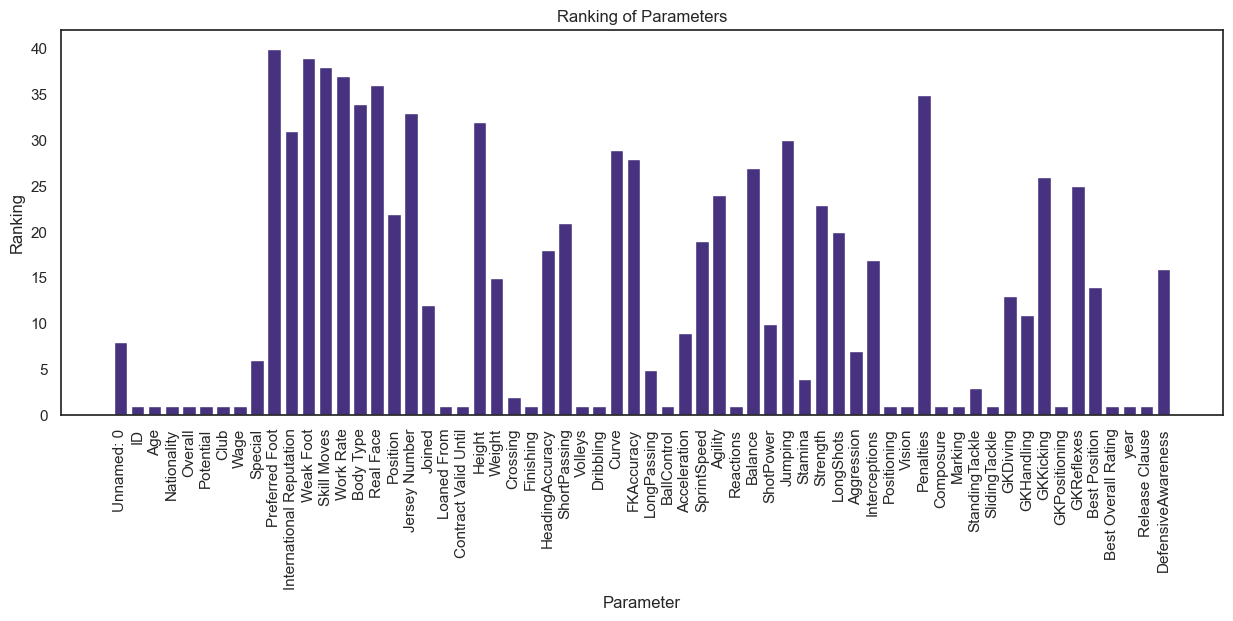

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.bar(range(len(selector.ranking_)), selector.ranking_)
plt.xticks(range(len(x_train.columns)), x_train.columns, rotation='vertical')
plt.xlabel("Parameter")
plt.ylabel("Ranking")
plt.title("Ranking of Parameters")
plt.show()


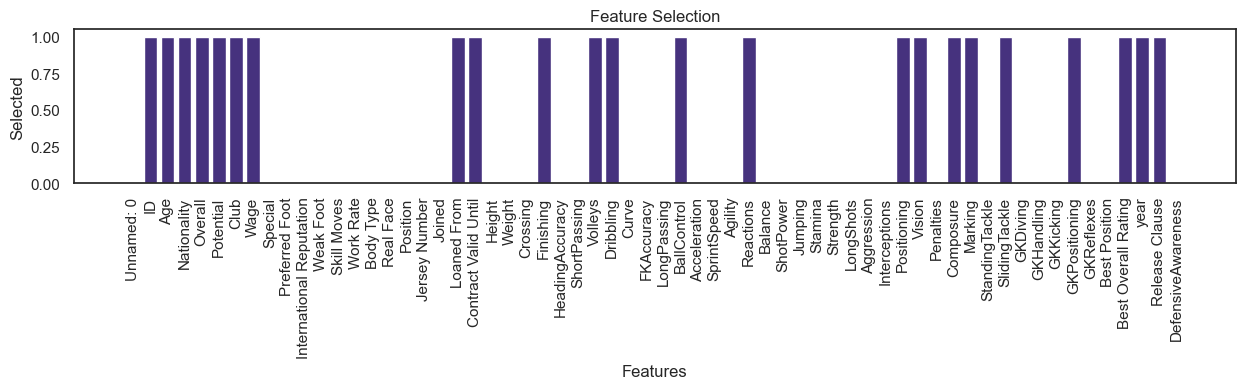

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,2))
plt.bar(x_train.columns, selector.support_)
plt.xticks(rotation='vertical')
plt.xlabel("Features")
plt.ylabel("Selected")
plt.title("Feature Selection")
plt.show()


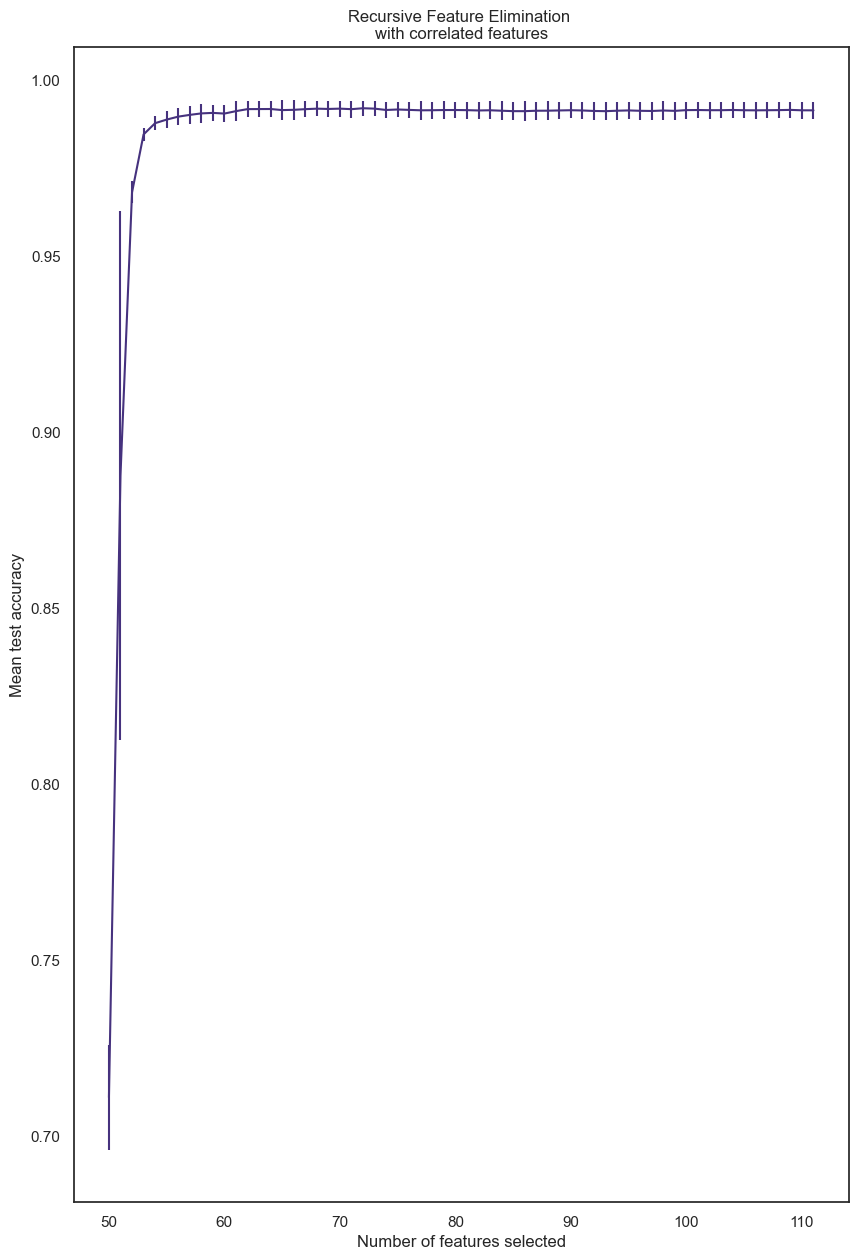

In [60]:
import matplotlib.pyplot as plt
min_features_to_select=50
n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure(figsize=(10,15))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    selector.cv_results_["mean_test_score"],
    yerr=selector.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

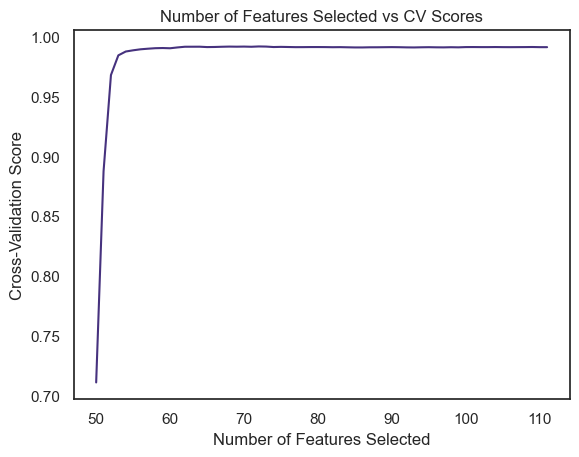

In [61]:
import matplotlib.pyplot as plt

n_features = range(min_features_to_select, n_scores + min_features_to_select)
cv_scores = selector.cv_results_["mean_test_score"]

plt.figure()
plt.plot(n_features, cv_scores)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score")
plt.title("Number of Features Selected vs CV Scores")
plt.show()

In [ ]:
import xgboost as xgb

clf_xgBoost = xgb.XGBRegressor(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
)
# Fit the models
clf_xgBoost.fit(x_train,y_train)

In [ ]:
from sklearn import preprocessing

importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

importance_df['mean'] = importance_df.mean(axis=1)

importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

In [ ]:
I=x[['LongShots','International Reputation','Work Rate', 'GKKicking','Joined','Penalties','Skill Moves','Height']]
for i in I:
    x=x.drop(i,axis=1)

In [ ]:
I=x[['Weight','Agility','Strength','ShotPower','Curve','HeadingAccuracy','Body Type']]
for i in I:
    x=x.drop(i,axis=1)

In [ ]:
I=x[['Nationality','Club','Interceptions','Acceleration', 'SprintSpeed','Composure','Contract Valid Until','FKAccuracy','Best Position', 'Stamina','Aggression']]
for i in I:
    x=x.drop(i,axis=1)

In [ ]:
x.head()

In [ ]:
x=x.drop('Unnamed: 0',axis=1)
x.info()

In [ ]:
t=x.columns
t

In [ ]:
data1=x
data1['Value']=y

In [ ]:
import random

Model Fitting

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x,y,random_state=42,test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestRegressor(n_estimators=200,random_state=100)


In [ ]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

models = [
    ('linear', LinearRegression()),
    ('ridge', Ridge(random_state = seed)),
    ('lasso', Lasso(random_state = seed, max_iter = 1000000)),
    ('elastic', ElasticNet(random_state = seed, max_iter = 1000000)),
    ('huber', HuberRegressor(max_iter = 1000000)),
    ('ard', ARDRegression()),
    ('passive', PassiveAggressiveRegressor(random_state = seed)),
    ('theilsen', TheilSenRegressor(random_state = seed)),
    ('gam', gam_wrapper(LinearGAM())),
    #('mlp', MLPRegressor(random_state = seed, max_iter = 1000000)),
    ('et', ExtraTreesRegressor(random_state = seed)),
    ('rf', RandomForestRegressor(random_state = seed)),
    ('xgb', XGBRegressor(random_state = seed)),
    ('lgb', LGBMRegressor(random_state = seed)),
    ('dart', LGBMRegressor(random_state = seed, boosting_type = 'dart')),
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0)),
    ('gb', GradientBoostingRegressor(random_state = seed)),
    ('hgb', HistGradientBoostingRegressor(random_state = seed)),
    ('ada', AdaBoostRegressor(random_state = seed)),
    ('knn', KNeighborsRegressor())
]

for (label, model) in models:
     score_list[label], oof_list[label], predict_list[label] = cross_val_score(
         Pipeline([
             ('impute', SimpleImputer()),
             (label, model)
         ]),
         label = label)

In [ ]:
x_train1=x_train
x_train1['Value']=y_train
x_train2=x_val
x_train2['Value']=y_val

In [ ]:
rfc.fit(x_train,y_train)

In [ ]:
ansr=rfc.predict(x_val)


Model Testing

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
g=r2_score(y_val,y_pred)
s=mean_squared_error(y_val,y_pred,squared=False)
g,s

In [ ]:
g=r2_score(y_val,ansr)
s=mean_squared_error(y_val,ansr,squared=False)
g,s

In [ ]:
ansa

In [ ]:
g=r2_score(y_val,ansa)
s=mean_squared_error(y_val,ansa,squared=False)
g,s

Loading Test Data

In [ ]:
test=pd.read_csv("test.csv")

In [ ]:
test.head()

In [ ]:
test.info()

In [ ]:
def convert_value(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('€', '').replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('€', '').replace('M', '')) * 1000000
        else:
            return float(value.replace('€', ''))
    else:
        return value

test['Release Clause'] = test['Release Clause'].apply(convert_value)
test['Wage']=test['Wage'].apply(convert_value)

In [ ]:
e=test.select_dtypes(include='object').columns
e

In [ ]:
for i in e:
    test[i] = pd.factorize(test[i])[0]

In [ ]:
test[e]

In [ ]:
test.head()

In [ ]:
x_columns=t.tolist()
test=test[x_columns]

In [ ]:
null=test.isnull().sum()
null1=null[null>0].index
null1

In [ ]:
for i in null1:
    test[i]=test[i].fillna(value=test[i].mode()[0])

In [ ]:
null=test.isnull().sum()
null1=null[null>0]
null1

Predicting the value of Test data

In [ ]:
ans= predictor.predict(test)

In [ ]:
ans8=rfc.predict(test)
ans8

Creating Submission File

In [ ]:
q=pd.read_csv("test.csv")

In [ ]:
a=q.Photo

In [ ]:
selected_data=pd.DataFrame({'Photo':a,'Value':ans})

In [ ]:

selected_data.to_csv('finale.csv', index=False)
